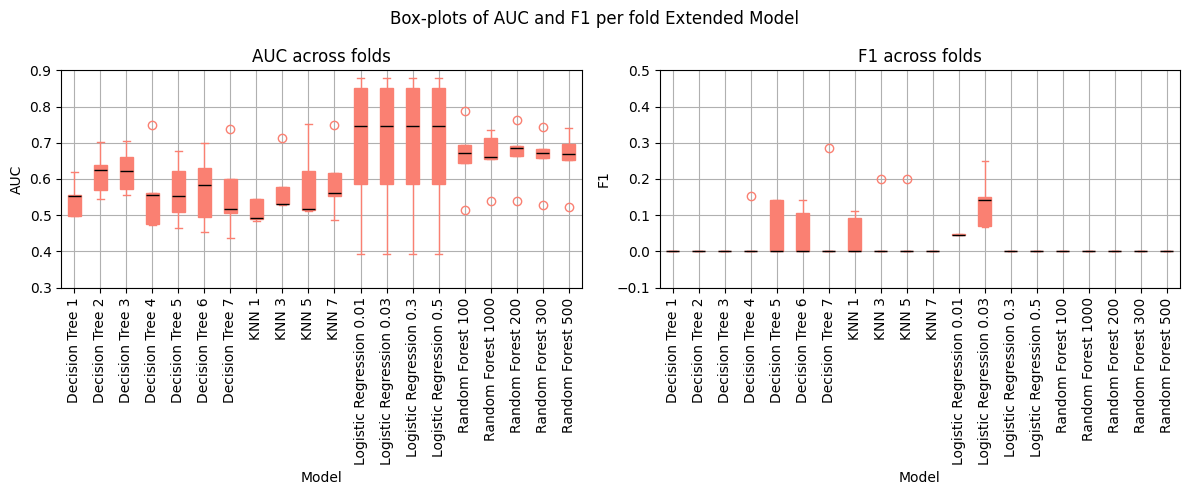

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# HAIR PLOT 
metrics_csv = Path("..") / "data" / "result-extended-1.csv"
df = pd.read_csv(metrics_csv)

# gather F1 / AUC into long form
f1_cols  = [c for c in df.columns if c.startswith("F1_fold")]
auc_cols = [c for c in df.columns if c.startswith("AUC_fold")]

long_f1  = df.melt(id_vars="Model", value_vars=f1_cols,
                   var_name="Fold", value_name="Value")
long_f1["Metric"] = "F1"

long_auc = df.melt(id_vars="Model", value_vars=auc_cols,
                   var_name="Fold", value_name="Value")
long_auc["Metric"] = "AUC"

long_df = pd.concat([long_f1, long_auc])

# colors to use
box_color = "salmon"
median_color = "black"

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

for ax, metric in zip(axes, ["AUC", "F1"]):
    data = long_df[long_df["Metric"] == metric]
    bp = data.boxplot(
        column="Value",
        by="Model",
        ax=ax,
        patch_artist=True,               # <-- allow color fill
        boxprops=dict(facecolor=box_color, color=box_color),
        medianprops=dict(color=median_color),
        whiskerprops=dict(color=box_color),
        capprops=dict(color=box_color),
        flierprops=dict(markeredgecolor=box_color)
    )
    ax.set_title(f"{metric} across folds")
    ax.set_xlabel("Model")
    ax.set_ylabel(metric)
    ax.tick_params(axis="x", rotation=90)

    if metric == "AUC":
        ax.set_ylim(0.3, 0.9)
    if metric == "F1":
        ax.set_ylim(-0.1, 0.5)

plt.suptitle("Box-plots of AUC and F1 per fold Extended Model")
plt.tight_layout()
plt.show()


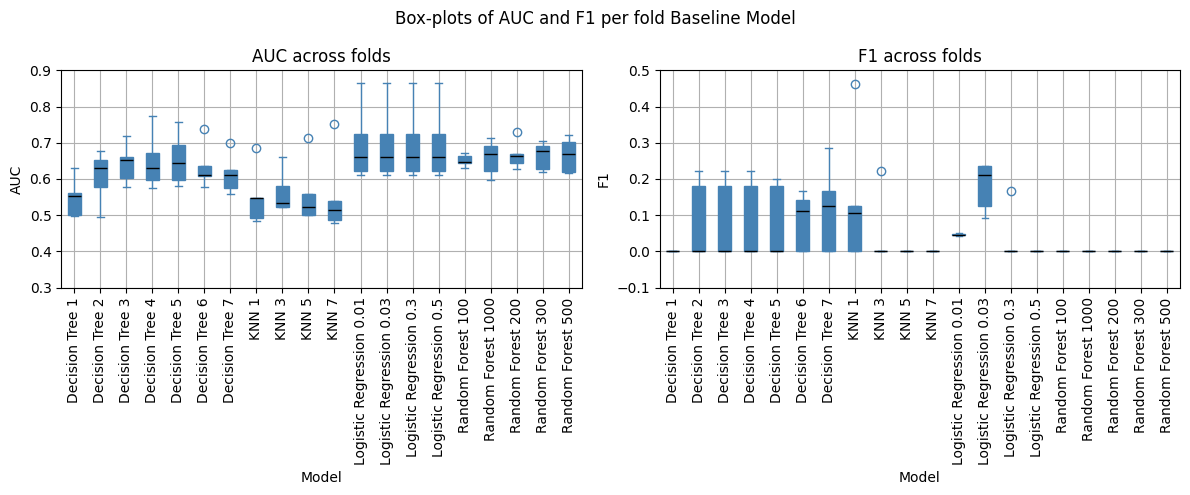

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# HAIR PLOT 
metrics_csv = Path("..") / "data" / "result-baseline-1.csv"
df = pd.read_csv(metrics_csv)

# gather F1 / AUC into long form
f1_cols  = [c for c in df.columns if c.startswith("F1_fold")]
auc_cols = [c for c in df.columns if c.startswith("AUC_fold")]

long_f1  = df.melt(id_vars="Model", value_vars=f1_cols,
                   var_name="Fold", value_name="Value")
long_f1["Metric"] = "F1"

long_auc = df.melt(id_vars="Model", value_vars=auc_cols,
                   var_name="Fold", value_name="Value")
long_auc["Metric"] = "AUC"

long_df = pd.concat([long_f1, long_auc])

# colors to use
box_color = "steelblue"
median_color = "black"

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

for ax, metric in zip(axes, ["AUC", "F1"]):
    data = long_df[long_df["Metric"] == metric]
    bp = data.boxplot(
        column="Value",
        by="Model",
        ax=ax,
        patch_artist=True,
        boxprops=dict(facecolor=box_color, color=box_color),
        medianprops=dict(color=median_color),
        whiskerprops=dict(color=box_color),
        capprops=dict(color=box_color),
        flierprops=dict(markeredgecolor=box_color)
    )
    ax.set_title(f"{metric} across folds")
    ax.set_xlabel("Model")
    ax.set_ylabel(metric)
    ax.tick_params(axis="x", rotation=90)

    # enforce AUC range 0.4–0.9
    if metric == "AUC":
        ax.set_ylim(0.3, 0.9)
    if metric == "F1":
        ax.set_ylim(-0.1, 0.5)

plt.suptitle("Box-plots of AUC and F1 per fold Baseline Model")
plt.tight_layout()
plt.show()


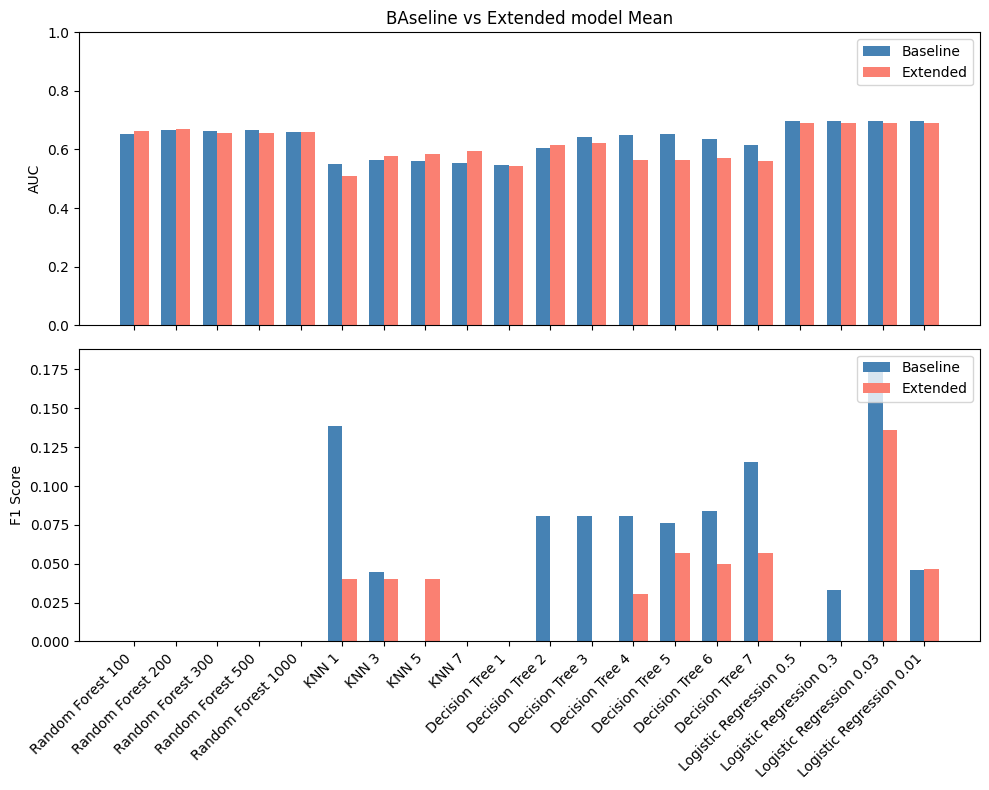

In [87]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ── 0. File paths ────────────────────────────────────────────────────────────
droot   = Path("..") / "data"
base_fp = droot / "result-baseline-1.csv"
ext_fp  = droot / "result-extended-1.csv"

# ── 1. Read CSVs robustly to handle commas inside fields ─────────────────────
sep_regex = r',(?=(?:[^"]*"[^"]*")*[^"]*$)'
base = pd.read_csv(base_fp, sep=sep_regex, engine='python',
                   quotechar='"', skipinitialspace=True)
ext  = pd.read_csv(ext_fp,  sep=sep_regex, engine='python',
                   quotechar='"', skipinitialspace=True)

# ── 2. Parse CI strings into numeric half-widths ─────────────────────────────
def parse_ci(ci_str):
    nums = re.findall(r"[-+]?\d*\.\d+|\d+", ci_str)
    if len(nums) < 2:
        raise ValueError(f"Cannot parse CI from: {ci_str!r}")
    low, high = map(float, nums[:2])
    return low, high

for df in (base, ext):
    df["AUC_err"] = df["AUC 95% CI"].apply(
        lambda s: abs(parse_ci(s)[1] - parse_ci(s)[0]) / 2
    )

# ── 3. Rename columns and merge on Model ─────────────────────────────────────
b = base.rename(columns={"AUC Mean":"AUC_base", "F1 Mean":"F1_base", "AUC_err":"AUC_err_base"})
e = ext .rename(columns={"AUC Mean":"AUC_ext",  "F1 Mean":"F1_ext",  "AUC_err":"AUC_err_ext"})
df = pd.merge(
    b[["Model","AUC_base","AUC_err_base","F1_base"]],
    e[["Model","AUC_ext","AUC_err_ext","F1_ext"]],
    on="Model"
)

# ── 4. Plot comparison ───────────────────────────────────────────────────────
n = len(df)
x = np.arange(n)
w = 0.35
colors_base = ["steelblue"] * n
colors_ext  = ["salmon"]     * n

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# AUC bars with error bars
ax1.bar(x - w/2, df["AUC_base"], width=w, color=colors_base, label="Baseline")
ax1.bar(x + w/2, df["AUC_ext"],  width=w, color=colors_ext, label="Extended")
ax1.legend(loc="upper right")
ax1.set_ylim(0, 1)
ax1.set_ylabel("AUC")
ax1.set_title("BAseline vs Extended model Mean")

# F1 bars
ax2.bar(x - w/2, df["F1_base"], width=w,
        color=colors_base, label="Baseline")
ax2.bar(x + w/2, df["F1_ext"],  width=w,
        color=colors_ext,  label="Extended")
ax2.legend(loc="upper right")
ax2.set_ylabel("F1 Score")

# X-axis labels
plt.xticks(x, df["Model"], rotation=45, ha="right")
plt.tight_layout()
plt.show()



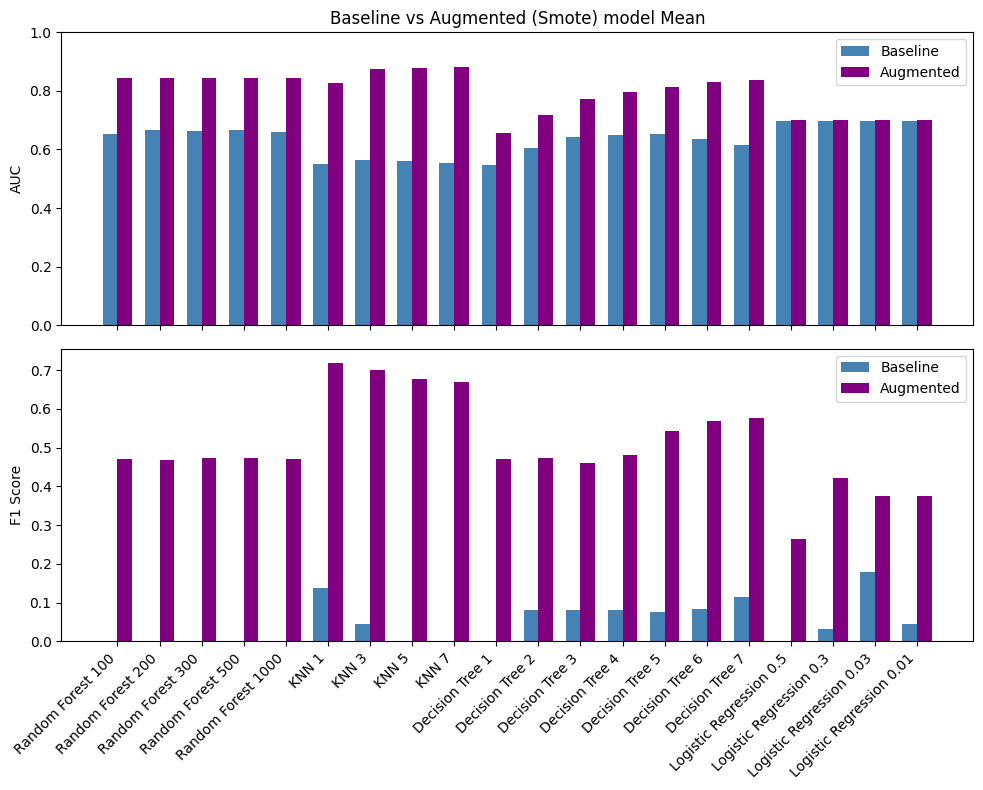

In [88]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ── 0. File paths ────────────────────────────────────────────────────────────
droot   = Path("..") / "data"
base_fp = droot / "result-baseline-1.csv"
ext_fp  = droot / "result-SMOTE-1.csv"

# ── 1. Read CSVs robustly to handle commas inside fields ─────────────────────
sep_regex = r',(?=(?:[^"]*"[^"]*")*[^"]*$)'
base = pd.read_csv(base_fp, sep=sep_regex, engine='python',
                   quotechar='"', skipinitialspace=True)
ext  = pd.read_csv(ext_fp,  sep=sep_regex, engine='python',
                   quotechar='"', skipinitialspace=True)

# ── 2. Parse CI strings into numeric half-widths ─────────────────────────────
def parse_ci(ci_str):
    nums = re.findall(r"[-+]?\d*\.\d+|\d+", ci_str)
    if len(nums) < 2:
        raise ValueError(f"Cannot parse CI from: {ci_str!r}")
    low, high = map(float, nums[:2])
    return low, high

for df in (base, ext):
    df["AUC_err"] = df["AUC 95% CI"].apply(
        lambda s: abs(parse_ci(s)[1] - parse_ci(s)[0]) / 2
    )

# ── 3. Rename columns and merge on Model ─────────────────────────────────────
b = base.rename(columns={"AUC Mean":"AUC_base", "F1 Mean":"F1_base", "AUC_err":"AUC_err_base"})
e = ext .rename(columns={"AUC Mean":"AUC_ext",  "F1 Mean":"F1_ext",  "AUC_err":"AUC_err_ext"})
df = pd.merge(
    b[["Model","AUC_base","AUC_err_base","F1_base"]],
    e[["Model","AUC_ext","AUC_err_ext","F1_ext"]],
    on="Model"
)

# ── 4. Plot comparison ───────────────────────────────────────────────────────
n = len(df)
x = np.arange(n)
w = 0.35
colors_base = ["steelblue"] * n
colors_ext  = ["purple"]     * n

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# AUC bars with error bars
ax1.bar(x - w/2, df["AUC_base"], width=w, color=colors_base, label="Baseline")
ax1.bar(x + w/2, df["AUC_ext"],  width=w, color=colors_ext, label="Augmented")
ax1.legend(loc="upper right")
ax1.set_ylim(0, 1)
ax1.set_ylabel("AUC")
ax1.set_title("Baseline vs Augmented (Smote) model Mean")

# F1 bars
ax2.bar(x - w/2, df["F1_base"], width=w,
        color=colors_base, label="Baseline")
ax2.bar(x + w/2, df["F1_ext"],  width=w,
        color=colors_ext,  label="Augmented")
ax2.legend(loc="upper right")
ax2.set_ylabel("F1 Score")

# X-axis labels
plt.xticks(x, df["Model"], rotation=45, ha="right")
plt.tight_layout()
plt.show()

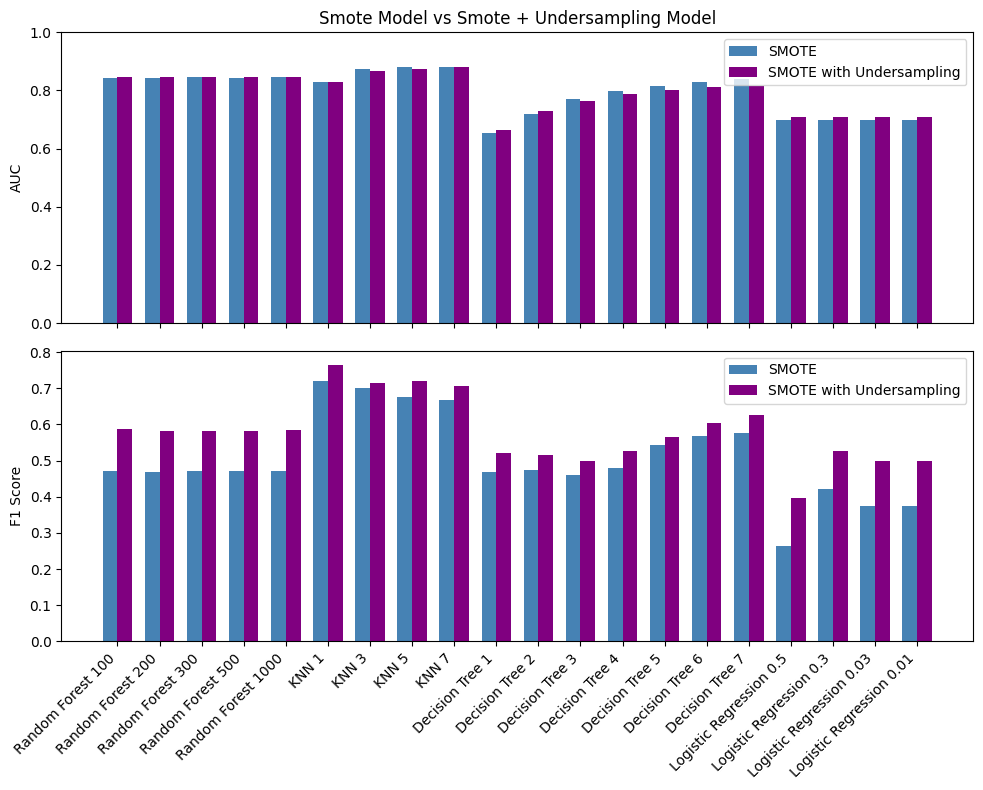

In [89]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ── 0. File paths ────────────────────────────────────────────────────────────
droot   = Path("..") / "data"
base_fp = droot / "result-SMOTE-1.csv"
ext_fp  = droot / "result-SMOTE+undersampling-data.csv"

# ── 1. Read CSVs robustly to handle commas inside fields ─────────────────────
sep_regex = r',(?=(?:[^"]*"[^"]*")*[^"]*$)'
base = pd.read_csv(base_fp, sep=sep_regex, engine='python',
                   quotechar='"', skipinitialspace=True)
ext  = pd.read_csv(ext_fp,  sep=sep_regex, engine='python',
                   quotechar='"', skipinitialspace=True)

# ── 2. Parse CI strings into numeric half-widths ─────────────────────────────
def parse_ci(ci_str):
    nums = re.findall(r"[-+]?\d*\.\d+|\d+", ci_str)
    if len(nums) < 2:
        raise ValueError(f"Cannot parse CI from: {ci_str!r}")
    low, high = map(float, nums[:2])
    return low, high

for df in (base, ext):
    df["AUC_err"] = df["AUC 95% CI"].apply(
        lambda s: abs(parse_ci(s)[1] - parse_ci(s)[0]) / 2
    )

# ── 3. Rename columns and merge on Model ─────────────────────────────────────
b = base.rename(columns={"AUC Mean":"AUC_base", "F1 Mean":"F1_base", "AUC_err":"AUC_err_base"})
e = ext .rename(columns={"AUC Mean":"AUC_ext",  "F1 Mean":"F1_ext",  "AUC_err":"AUC_err_ext"})
df = pd.merge(
    b[["Model","AUC_base","AUC_err_base","F1_base"]],
    e[["Model","AUC_ext","AUC_err_ext","F1_ext"]],
    on="Model"
)

# ── 4. Plot comparison ───────────────────────────────────────────────────────
n = len(df)
x = np.arange(n)
w = 0.35
colors_base = ["steelblue"] * n
colors_ext  = ["purple"]     * n

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# AUC bars with error bars
ax1.bar(x - w/2, df["AUC_base"], width=w, color=colors_base, label="SMOTE")
ax1.bar(x + w/2, df["AUC_ext"],  width=w, color=colors_ext, label="SMOTE with Undersampling")
ax1.legend(loc="upper right")
ax1.set_ylim(0, 1)
ax1.set_ylabel("AUC")
ax1.set_title("Smote Model vs Smote + Undersampling Model")

# F1 bars
ax2.bar(x - w/2, df["F1_base"], width=w,
        color=colors_base, label="SMOTE")
ax2.bar(x + w/2, df["F1_ext"],  width=w,
        color=colors_ext,  label="SMOTE with Undersampling")
ax2.legend(loc="upper right")
ax2.set_ylabel("F1 Score")

# X-axis labels
plt.xticks(x, df["Model"], rotation=45, ha="right")
plt.tight_layout()
plt.show()